# k-means analysis of classical phase transition: 2D Ising model

In [1]:
#import of classical modules used
import numpy as np
import random, math
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
import time
from collections import defaultdict
import threading
import pickle
from scipy.optimize import curve_fit

## Autocorrelation time of the magnetization

In order to study the autocorrelation time of the magnetization we use the code in the `autocorrelation.py` file, in particular:
- the `AutoC` function takes in input a dat file containing the magnetizations produced and estimates the integrated autocorrelation time;
- the `mean_and_err` copmutes the mean and the varience over the simultations for every temperature.

In [2]:
from autocorrelation import AutoC, mean_and_err

We will carry the analysis using single spin and cluster updates:
- the code in the `Magnetization_SingleFlipUpdates_Ising2D.py` perform a simulation of the 2D Ising model with the Metropolis Algorithm (single flip updates) and returns the magnetization;
- the code in the `Magnetization_WolffClusterUpdates_Ising2D.py` perform a simulation of the 2D Ising model with the Wolff Algorithm (cluster updates) and returns the magnetization.

We perfomed the simulations for the following values of temperatures $[1.,2.269,3.0]$.

In [3]:
T_list = [1.,2.269,3.0]          # temperatures

In [4]:
#colormap for plot
cmap=matplotlib.colormaps['coolwarm']
norm_cmap = matplotlib.colors.Normalize(vmin=T_list[0],vmax=T_list[-1])

The simuations were performened $10$ times.

In [5]:
n_bins = 10                     # number of simulations
i_bins = range(n_bins)

### Autocorrelation Wolff

In the case of the Wolff algorithm we choose the following paramenters 

| |variable name|#steps|
|-|-|-|
|mesurements|N_sweeps| 2000|
|equilibration |N_eq | 1000|
|cycle|N_flips |1 |



The mesurements are saved in the directory `./MagnetizationWolff/`, and the file name have the following structure:
```python
f"{i}-Magnetization_{L}L_{T:.3f}T_{N_sweeps}Nsw_{N_eq}Neq_{N_flips}Nfl-Wolff.dat"
```
where `i` refers to the i-th simulation.

In [6]:
N_sweeps = 2_000        # Number of steps for the measurements
N_eq     = 1_000        # Number of equilibration steps before the measurements start
N_flips  = 1            # Number of steps between measurements

L_list = [8,12,16,20,24,28,32,36,40]    #system sizes

At_tau_WCU = {i: defaultdict(list) for i in i_bins}
At_rho_WCU = {i: defaultdict(list) for i in i_bins}
M_WCU = {i: defaultdict(list) for i in i_bins}

cdir = "./MagnetizationWolff/"

# computation of all autocorrelation times
for i in i_bins:
    for T in T_list[:]:
        for L in L_list:
            MFile = f'{cdir}{i}-Magnetization_{L}L_{T:.3f}T_{N_sweeps}Nsw_{N_eq}Neq_{N_flips}Nfl-Wolff.dat'
            Magnetization = np.loadtxt(MFile)
            M_WCU[i][T].append(Magnetization)
            
            rho,tau = AutoC(MFile)
            At_tau_WCU[i][T].append(tau)
            At_rho_WCU[i][T].append(rho)
            
# compute mean and standard deviation over the i_bins measuraments
At_tau_WCU_mean, At_tau_WCU_err = mean_and_err(At_tau_WCU,i_bins,T_list)

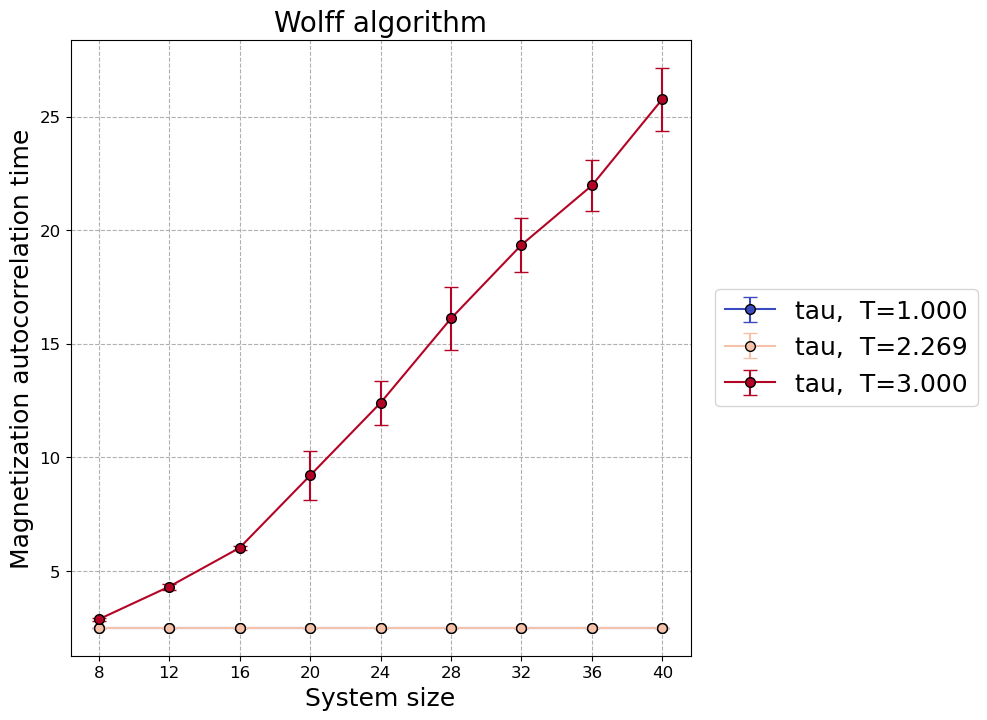

In [7]:
# plot of the results
plt.figure(figsize=(8,8))
plt.title("Wolff algorithm",fontsize=20)
plt.xlabel("System size",fontsize=18)
plt.ylabel("Magnetization autocorrelation time",fontsize=18)
plt.xticks(L_list,fontsize=12)
plt.yticks(fontsize=12)

for T in T_list[:]:
    plt.errorbar(L_list,At_tau_WCU_mean[T],yerr=At_tau_WCU_err[T],capsize=5,
                 label=f'tau,  {T=:.3f}', marker='o', mfc=cmap(norm_cmap(T)),
                 mec='black', ms=7, mew=1,color=cmap(norm_cmap(T)))
        
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0,fontsize=18)
plt.grid(linestyle='--')

#uncomment the following line to save the plot
#plt.savefig(f'./Plots/AutocorrelationMagnetizationWolff_{N_sweeps}Nsw_{N_eq}Neq_{N_flips}Nfl.pdf',bbox_inches = 'tight')
plt.show()

### Autocorrelation MetropolisSingleFlip

In the case of the Metropolis algorithm we choose the following paramenters 

||variable name|#steps|
|----|----|---|
|mesurements|`N_sweeps`| 20000|
|equilibration |`N_eq` | 10000|
|cycle|`N_flips` |400|

In [8]:
N_sweeps = 20_000          # Number of steps for the measurements
N_eq     = 10_000          # Number of equilibration steps before the measurements start 
N_flips  = 400             # Number of steps between measurements 

L_list = [8,10,12,14,16,18,20]  #system sizes

The computation of the autocorrelation function where performed by the `autocorrelation.py` file and saved in the directory `./AutoCorrelation/`.

In [9]:
# retrive the analysis done
cdirAC = './AutoCorrelation/'

with open(f'{cdirAC}AutoCtau-Magnetization_{N_sweeps}Nsw_{N_eq}Neq_{N_flips}Nfl-SingleFlip.pickle', 'rb') as f:
    AtM_tau_MSF = pickle.load(f)
    
with open(f'{cdirAC}AutoCrho-Magnetization_{N_sweeps}Nsw_{N_eq}Neq_{N_flips}Nfl-SingleFlip.pickle', 'rb') as f:
    AtM_rho_MSF = pickle.load(f)

In [10]:
# In this block we get the magnetization from the simulations

M_MSF = {i: {T:[0 for _ in L_list] for T in T_list} for i in i_bins}

cdirM = './MagnetizationSingleFlip/'

def get_observable(i,T,L):
    L_index = L_list.index(L)
    MFile = f'{cdirM}{i}-Magnetization_{L}L_{T:.3f}T_{N_sweeps}Nsw_{N_eq}Neq_{N_flips}Nfl-SingleFlip.dat'
    Magnetization = np.loadtxt(MFile)
    M_MSF[i][T][L_index] = Magnetization
            
# parallel execution of the code
threads = []
for T in T_list:
    for L in L_list:
        for i in i_bins:
            t = threading.Thread(target=get_observable,args=[i,T,L])
            t.start()
            threads.append(t)
for thread in threads:
    thread.join()
    
print("observable retrived")

observable retrived


In [11]:
#Auxiliar functions to plot magnetization and the autocorrelation function

def plot_observable(bins,Ob_dict,Ob_name):
    '''
    Plot the observable of the bins simulations.
    '''
    for L_index,L_plot in enumerate(L_list):
        for i in bins:
            Ob = Ob_dict[i]
            plt.figure(figsize=(6,3))
            plt.title(f'{i=} {Ob_name} L={L_plot}')
            plt.gca().set_ylim((-2.1,1.1))
            for T in T_list:
                plt.plot(Ob[T][L_index]/L_plot**2,color=cmap(norm_cmap(T)),label=f'{T=:.3f}')
            plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()
    
def plot_autocorrelation_function(bins,At_rho_dict,At_name):
    '''
    Plot the autocorrelation time of the bins simulations
    '''
    for L_index,L_plot in enumerate(L_list):
        for i in bins:
            At_rho = At_rho_dict[i]
            plt.figure(figsize=(4,2))
            plt.title(f'{i=} Autocorrelation function {At_name} L={L_plot}')
            for T in T_list[:]:
                plt.plot(At_rho[T][L_index],color=cmap(norm_cmap(T)),label=f'{T=:.3f}')
            plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()

In [12]:
#plot magnetization
#plot_observable([0],M_MSF,'Magnetization per spin')

In [13]:
#plot autocorrelation function magnetization
#plot_autocorrelation_function([0],AtM_rho_MSF,"magnetization")

In the following plot we also fit according to $L^z$ to detect the critical exponent $z$.
We expect that the autocorrelation time grows according to $\tau \simeq L^2$ at the critical temperature $T_c \simeq 2.269$ (critical slowing down of metropolis algorithm).

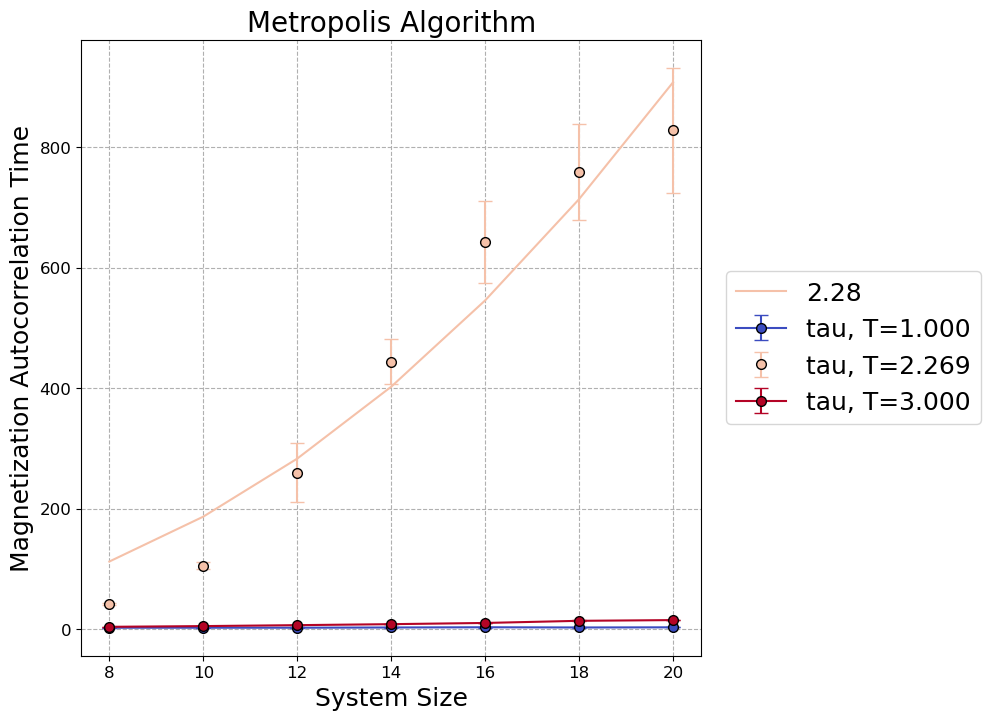

In [14]:
def fitting_curve(x,a,b):
    return a*x**b

fit = True

At_tau, title = AtM_tau_MSF, "Magnetization"

# calculate mean and variance of the n_bins simulations
At_tau_mean, At_tau_err = mean_and_err(At_tau,i_bins,T_list)

# plot of the results

plt.figure(figsize=(8,8))
plt.title("Metropolis Algorithm",fontsize=20)
plt.xlabel("System Size",fontsize=18)
plt.ylabel(f"{title} Autocorrelation Time",fontsize=18)
plt.xticks(L_list,fontsize=12)
plt.yticks(fontsize=12)

for T in T_list:
    if fit and abs(T - 2.269)<1e-15:
        popt, pcov = curve_fit(fitting_curve, L_list, At_tau_mean[T])
        plt.plot(L_list[:],fitting_curve(np.array(L_list),*popt),color=cmap(norm_cmap(T)), label=f"{popt[1]:.2f}")
        
        plt.errorbar(L_list,At_tau_mean[T],yerr=At_tau_err[T],fmt=' ',capsize=5,
                 label=f'tau, {T=:.3f}', marker='o', mfc=cmap(norm_cmap(T)),
                 mec='black', ms=7, mew=1,color=cmap(norm_cmap(T)))
    else:
        plt.errorbar(L_list,At_tau_mean[T],yerr=At_tau_err[T],capsize=5,
                 label=f'tau, {T=:.3f}', marker='o', mfc=cmap(norm_cmap(T)),
                 mec='black', ms=7, mew=1,color=cmap(norm_cmap(T)))

        plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0,fontsize=18)
plt.grid(linestyle='--')
#plt.savefig(f'./Plots/Autocorrelation{title}Metropolis_{N_sweeps}Nsw_{N_eq}Neq_{N_flips}Nfl_{len(i_bins)}bins.pdf',bbox_inches = 'tight')
plt.show()

# k-means analysis

At first step we perform an analysis on the autocorrelation time, so that later we can choose the right number of flips to get uncorrelated spin configuration.
We can see in the first plot, Wolff algortihm has a critical slow down for temperature above $T_c \simeq 2.269$.
Since the range of temperature for the k-means analysis is from $1.6$ to $2.9$, we calculate the estimated autocorrelation time for $T = [2.5,2.7,2.9]$ and $L=[20,40,60,80,100]$.
As done before we perform the simulation $10$ times and plot the mean and standard variance of the results obtained.

In [15]:
N_sweeps = 2_000        # Number of steps for the measurements
N_eq     = 2_000      # Number of equilibration steps before the measurements start 
N_flips  = 1            # Number of steps between measurements 

T_list = [2.5,2.7,2.9]
L_list = [20,40,60,80,100]

i_bins = range(10)

At_tau_T = {i: defaultdict(list) for i in i_bins}

cdir = "./MagnetizationWolff/"

for i in i_bins:
    for T in T_list:
        for L in L_list:
            MFile = f'{cdir}{i}-Magnetization_{L}L_{T:.3f}T_{N_sweeps}Nsw_{N_eq}Neq_{N_flips}Nfl-Wolff.dat'
            rho,tau = AutoC(MFile)
            At_tau_T[i][T].append(tau)
            
At_tau_T_mean, At_tau_T_err = mean_and_err(At_tau_T,i_bins,T_list)

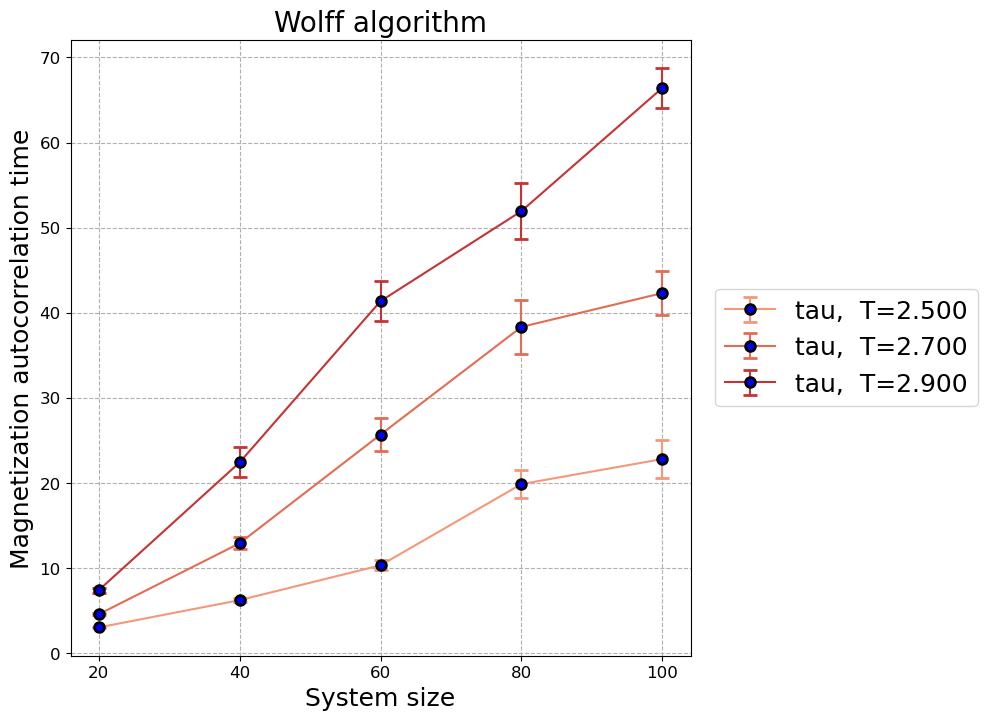

In [16]:
# plot of the results
plt.figure(figsize=(8,8))
plt.title("Wolff algorithm",fontsize=20)
plt.xlabel("System size",fontsize=18)
plt.ylabel("Magnetization autocorrelation time",fontsize=18)
plt.xticks(L_list,fontsize=12)
plt.yticks(fontsize=12)

for T in T_list:
    plt.errorbar(L_list,At_tau_T_mean[T],yerr=At_tau_T_err[T],capsize=5,
                 label=f'tau,  {T=:.3f}', marker='o', mfc='blue',
                 mec='black', ms=7, mew=2,color=cmap(norm_cmap(T)))

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0,fontsize=18)

plt.grid(linestyle='--')
plt.savefig(f'./Plots/AutocorrelationMagnetizationWolff_largesize_{N_sweeps}Nsw_{N_eq}Neq_{N_flips}Nfl.pdf',bbox_inches = 'tight')
plt.show()

To ensure uncorrelated spin configuration we set the number of flips to be $3$ times the estimated autocorrelation time estemimated.
Since the autocorrelation function decays as $e^{-t/\tau}$, then with $3\tau$ the autocorrelation is around $e^{-3}\sim 0.0499$.

In [17]:
print(f"Proposed number of cycle at different sizes:\n\nT \t cycle steps\n")

for i,L in enumerate(L_list):
    tau_max = max([At_tau_T_mean[T][i] + At_tau_T_err[T][i] for T in T_list])
    N_flips_test = math.ceil(3*tau_max)    
    print(f"{L} \t {N_flips_test}")

Proposed number of cycle at different sizes:

T 	 cycle steps

20 	 24
40 	 73
60 	 132
80 	 166
100 	 207


Cycle steps in fucntion of the system size:

|system size| #cycle steps|
|-----------|-------------|
|20|20|
|40|60|
|60|100|
|80|150|
|100|200|

The code in the `SpinConfiguration_WolffClusterUpdates_Ising2D.py` perform a simulation of the 2D Ising model with the Wolff Algorithm (cluster updates) and save on a file the spin configurations.

The mesurements are saved in the directory `./SpinConfiguration/`, and the file name have the following structure:
```python
f"spin_config_{L}L_{T:.1f}T_{N_flips}flips.dat"
```
where `N_flips` is the number of cycles step used (they depend on the system size, following previous table).

We generate $100$ spin configuration for each choice of temperature $T = [1.6,1.7,\dots,2.8,2.9]$ and size system $L = [20,40,60,80,100]$.
For each system size we collect all the spin configuration in a matrix and then apply PCA to dedect the phase transition (see https://arxiv.org/pdf/1606.00318.pdf).

We plot the projection of the data on the space generated by the two leading principal components given by the PCA

In [18]:
from sklearn.decomposition import PCA

In [19]:
L_dict_flips= {20:20, 40:60, 60:100, 80:150, 100:200} # L:N_flips

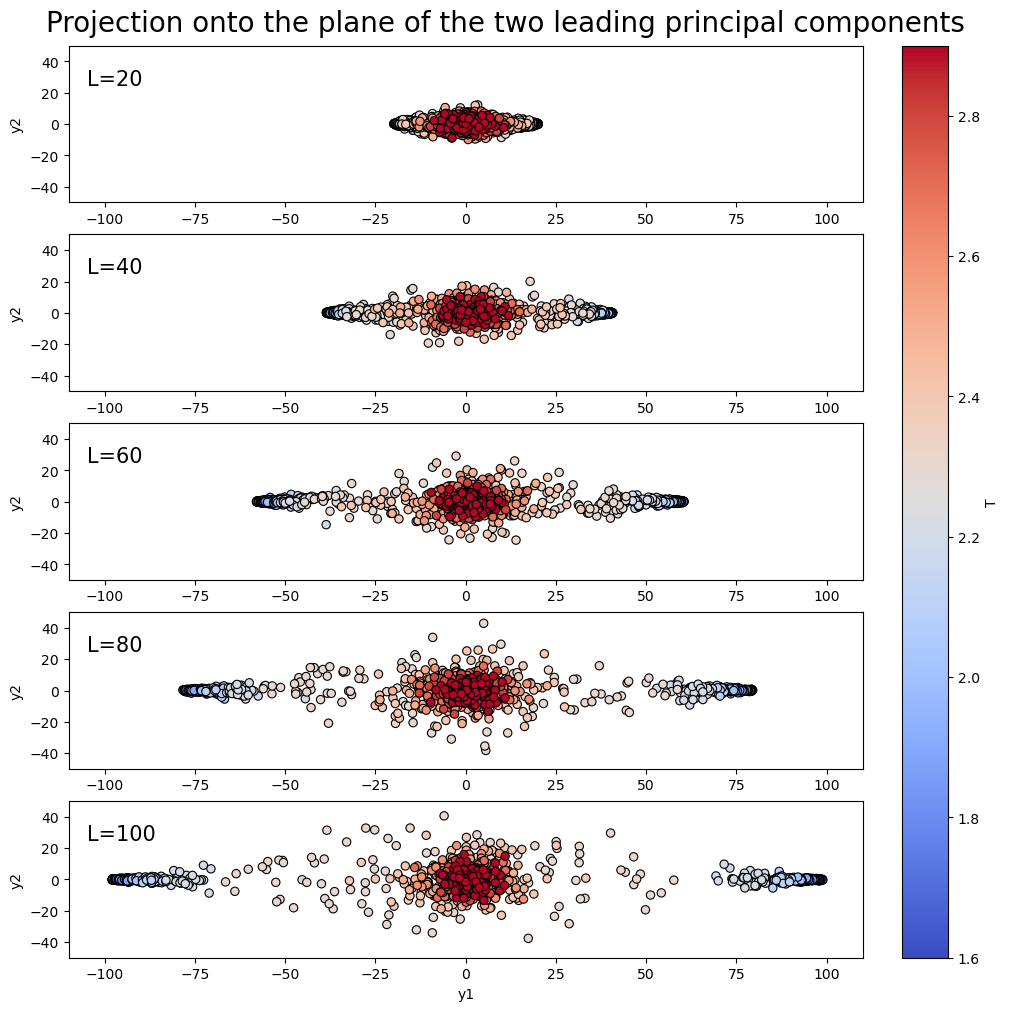

In [20]:
L_list = [20,40,60,80,100]
T_list = np.arange(1.6,2.99,0.1)

fig, axes = plt.subplots(len(L_list),1,figsize=(10,10),layout='constrained')
fig.suptitle('Projection onto the plane of the two leading principal components',fontsize=20)
plt.setp(axes,xlim=(-110,110),ylim=(-50,50))

cdir = './SpinConfiguration/'

for i,L in enumerate(L_list):
    SC_all=[]
    T_all=[]
    #import all spin configurations
    for T in T_list[:]:
        SC = np.loadtxt(f'{cdir}spin_config_{L}L_{T:.1f}T_{L_dict_flips[L]}flips.dat')
        for sc in SC:
            T_all.append(T)
            SC_all.append(sc)
    
    # perform principal component analisys
    SC_all_pca = PCA(n_components=2).fit_transform(SC_all)
    
    #plot onto the plane of the two leading principal components
    axes[i].set(ylabel='y2')
    axes[i].text(-105,25,f"{L=}",horizontalalignment='left', size=15)
    pl=axes[i].scatter(SC_all_pca[:,0],SC_all_pca[:,1],c=T_all,cmap="coolwarm",edgecolor='black',linewidths=.8)

fig.colorbar(pl,ax=axes,label='T')
plt.gca().set(xlabel='y1')
#plt.savefig(f'./Plots/k-means_analysis-projection2D.pdf')
plt.show()

We plot the projection of the data on the space generated by the three leading principal components given by the PCA

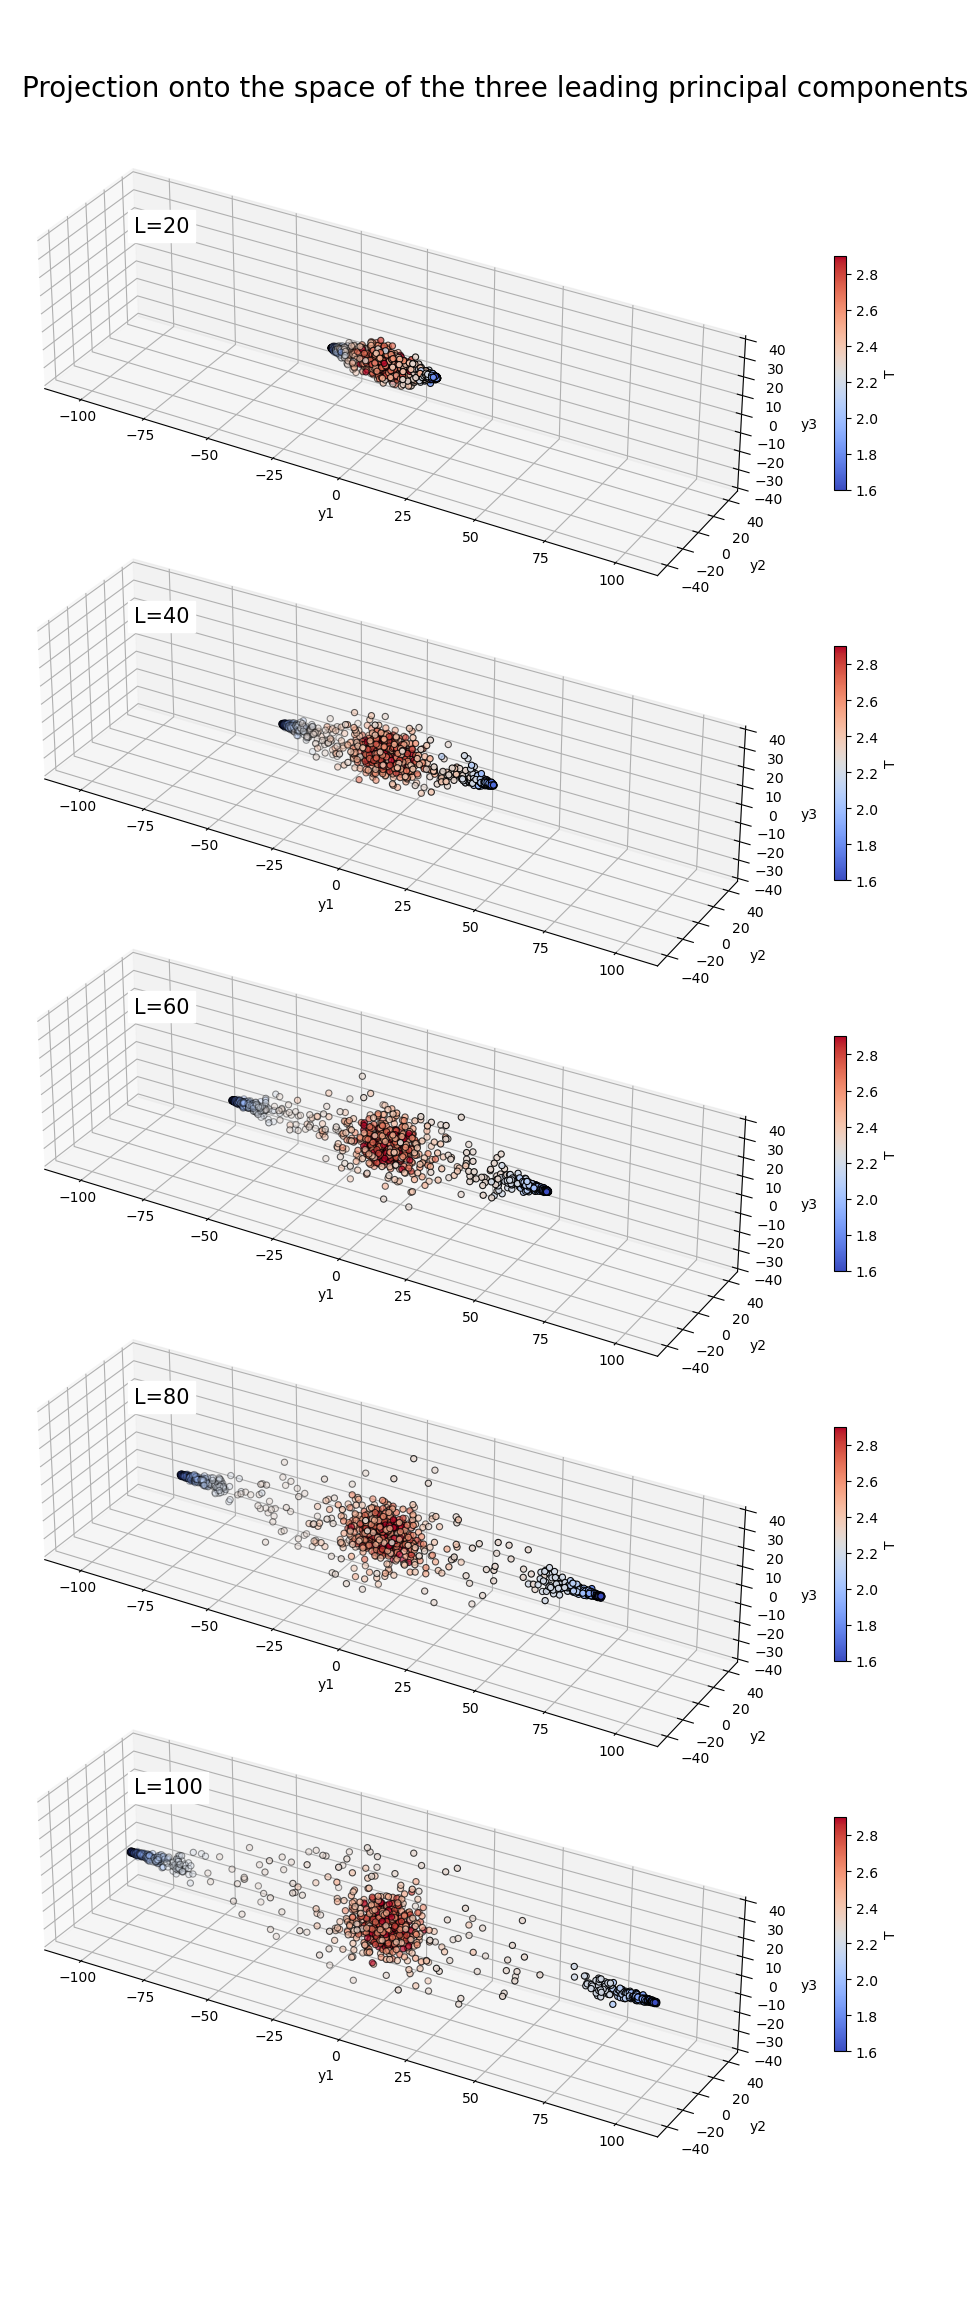

In [21]:
L_list = [20,40,60,80,100]
T_list = np.arange(1.6,2.99,0.1)

fig, axes = plt.subplots(len(L_list),1,figsize=(10,30),subplot_kw=dict(projection='3d'))

fig.suptitle('Projection onto the space of the three leading principal components',fontsize=20,y = 0.95)
plt.setp(axes,xlim3d=(-110,110),ylim3d=(-50,50),zlim3d=(-40,40))

cdir = './SpinConfiguration/'

for i,L in enumerate(L_list):
    SC_all=[]
    T_all=[]
    #import all spin configurations
    for T in T_list[:]:
        SC = np.loadtxt(f'{cdir}spin_config_{L}L_{T:.1f}T_{L_dict_flips[L]}flips.dat')
        for sc in SC:
            T_all.append(T)
            SC_all.append(sc)
    
    # perform principal component analisys
    SC_all_pca = PCA(n_components=3).fit_transform(SC_all)
    
    #plot onto the space of the three leading principal components
    axes[i].set_ylabel('y2')
    axes[i].set_xlabel('y1',labelpad = 20)
    axes[i].set_zlabel('y3')
    axes[i].text(-105,25,20,f"{L=}",horizontalalignment='left', size=15, backgroundcolor='w')
    pl= axes[i].scatter(SC_all_pca[:,0],SC_all_pca[:,1],SC_all_pca[:,2],c=T_all,cmap="coolwarm",edgecolor='black',linewidths=.8)
    axes[i].set_box_aspect([4,1,1])
    axes[i].patch.set_alpha(0) # 0 opacity
    fig.colorbar(pl,ax=axes[i],label='T',shrink=0.3,pad = 0.1)
    
fig.tight_layout()
fig.subplots_adjust(bottom = 0.2,hspace=-0.5)

#plt.savefig(f'./Plots/k-means_analysis-projection3D.pdf',bbox_inches='tight')
plt.show()

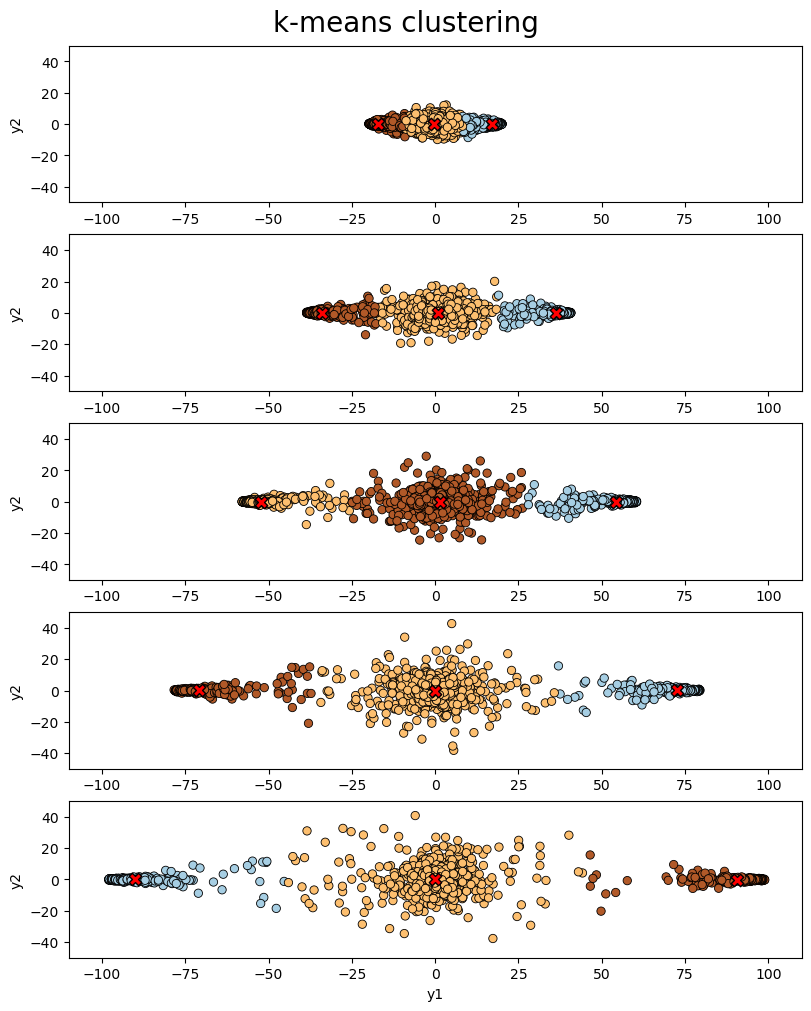

In [22]:
from sklearn.cluster import KMeans
fig, axes = plt.subplots(len(L_list),1,figsize=(8,10),layout='constrained')
fig.suptitle('k-means clustering',fontsize=20)

for i,L in enumerate(L_list):
    SC_all=[]
    T_all=[]
    for T in np.arange(1.6,3.0,0.1):
        SC = np.loadtxt(f'{cdir}spin_config_{L}L_{T:.1f}T_{L_dict_flips[L]}flips.dat')
        for a in SC:
            T_all.append(T)
            SC_all.append(a)
    
    SC_pca = PCA(n_components=2).fit_transform(SC_all)
    
    kmeans = KMeans(n_clusters=3,random_state=0,n_init="auto").fit(SC_pca)
    
    labels=kmeans.labels_
    axes[i].scatter(SC_pca[:,0],SC_pca[:,1],c=labels.astype(float),cmap='Paired',edgecolor='black',linewidths=.6)
    axes[i].set_xlim([-110,110])
    axes[i].set_ylim([-50,50])
    axes[i].set(ylabel='y2')
    
    #plot centroids
    Xc,Yc = list(zip(*kmeans.cluster_centers_))
    axes[i].scatter(Xc,Yc,marker='X',s=80, color='red', edgecolor='black')

#plt.savefig(f'./Plots/k-means_analysis.pdf')
plt.gca().set(xlabel='y1')
plt.show()